In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
import random
random.seed(0)
tf.random.set_seed(0)
np.random.seed(0)

## **Load the Data**

In [2]:
from keras.datasets import mnist
def load_data():
  (X_train, y_train), (X_test, y_test) = mnist.load_data()
  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)
  return (X_train, y_train), (X_test, y_test)

In [3]:
(X_train, y_train), (X_test, y_test) = load_data()

In [4]:
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
def preprocess_data(data):
  scaler = StandardScaler()
  data_std = scaler.fit_transform(data)
  n_components = 30
  pca = PCA(n_components=n_components)
  data_pca = pca.fit_transform(data_std)
  return data_pca

In [5]:
X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)

In [6]:
train_data_0 = pd.DataFrame(X_train[y_train == 0])
train_data_1 = pd.DataFrame(X_train[y_train == 2])[:1000]
train_data = pd.DataFrame(pd.concat([train_data_0,train_data_1]))
train = train_data.reset_index(drop = True)

train_label_0 = pd.DataFrame(y_train[y_train == 0])
train_label_1 = pd.DataFrame(y_train[y_train == 2])[:1000]
train_data_label = pd.DataFrame(pd.concat([train_label_0,train_label_1]))
y_train = np.array(train_data_label.reset_index(drop = True))
y_train = np.array([0 if elem==0 else 1 for elem in y_train])

In [7]:
test_data_0 = pd.DataFrame(X_test[y_test.flatten() == 0])
test_data_1 = pd.DataFrame(X_test[y_test.flatten() == 2])[:200]
test_data = pd.DataFrame(pd.concat([test_data_0,test_data_1]))
test = test_data.reset_index(drop = True)

test_label_0 = pd.DataFrame(y_test[y_test == 0])
test_label_1 = pd.DataFrame(y_test[y_test == 2])[:200]
test_data_label = pd.DataFrame(pd.concat([test_label_0,test_label_1]))
y_test = np.array(test_data_label.reset_index(drop = True))
y_test = np.array([0 if elem==0 else 1 for elem in y_test])

In [8]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
train = np.array(train)
train = train / train.sum(axis=1, keepdims=True)
train = np.clip(train,0.0000005,None)

In [9]:
scaler = MinMaxScaler()
test = scaler.fit_transform(test)
test = np.array(test)
test = test / test.sum(axis=1, keepdims=True)
test = np.clip(test,0.0000005,None)

##**Parameter Estimaion**

In [10]:
def moment_initialization(data):
  mean = np.mean(data,axis=0)
  mean_square = np.mean(data**2,axis=0)
  alpha = np.zeros(data.shape[1])
  for k in range(data.shape[1]):
    alpha[k] = mean[k]*(mean[k]-mean_square[k])/(mean_square[k]-(mean[k])**2)
  return alpha

In [11]:
from scipy.special import gamma, digamma, gammaln, psi,polygamma
def log_dir(row,alpha):
  q = gammaln(np.sum(alpha)) - np.sum(gammaln(alpha)) + np.sum((alpha-1)*np.log(row))
  return q

In [12]:
def normalize_alpha(arr, m, M):
    min_val = min(arr)
    max_val = max(arr)
    normalized_arr = []

    for value in arr:
        normalized_value = m + ((value - min_val) * (M - m) / (max_val - min_val))
        normalized_arr.append(normalized_value)

    return normalized_arr

In [13]:
def calcul_inv_hess_vect(data,alpha):
  (N, K) = data.shape
  q = N*float(polygamma(1,np.sum(alpha)))
  inv_S = np.diag([-N/np.clip(float(polygamma(1,alpha[m])),10**(-7),None) for m in range(K)])
  a = np.ones(K).reshape(-1,1)
  inv_hess = inv_S + np.dot(np.dot(inv_S,a),np.dot(np.transpose(a),inv_S))/((1/q)*np.dot(np.dot(np.transpose(a),inv_S),a))
  return inv_hess

In [14]:
def derivative(data,alpha_old):
  (N, K) = data.shape
  der_vect_alpha = np.zeros(K)
  for s in range(K):
    der_vect_alpha[s] =N*(psi(np.sum(alpha_old)) - psi(alpha_old[s])) + np.sum(np.log(data[:,s]))
  return der_vect_alpha

In [15]:
def update_alpha(data,alpha_old):
  inv_hess = calcul_inv_hess_vect(data,alpha_old)
  der_param = derivative(data,alpha_old)
  alpha_new = alpha_old - np.dot(inv_hess,der_param)
  alpha_new = np.abs(alpha_new)
  alpha_new = np.array(normalize_alpha(np.array(alpha_new),0.1,5))
  return alpha_new

In [16]:
alpha_zero =  [4.6324234,  4.57498802, 0.28223619, 1.64494705, 1.60651716, 3.61065611,
 0.31706543, 4.95545465, 1.18229745, 3.24368056, 1.76243255, 4.67034776,
 1.80246929, 4.52731348, 1.6780199,  1.13339735 ,2.1744383,  0.44859531,
 1.72104476, 4.72775289, 1.92537735, 0.87191059, 4.15428023, 0.76748645,
 0.10028811, 1.24557244, 1.3335847,  1.23298356, 3.96404402, 1.15583134]

In [17]:
'''alpha_zero = np.random.uniform(low=0.1, high=5, size=(train.shape[1],))
print('alpha_zero = ',alpha_zero)'''
alpha_old = alpha_zero

In [18]:
max_iter = 5
alpha_old = alpha_zero
for j in range(max_iter):
  alpha_new = update_alpha(train,alpha_old)
  alpha_old = alpha_new

##**Feature mapping**

In [19]:
train_df = pd.DataFrame(train)
train_df['new_feature'] = [log_dir(row,alpha_new) for row in train]

test_df = pd.DataFrame(test)
test_df['new_feature'] = [log_dir(row,alpha_new) for row in test]

In [20]:
train_f = np.array(train_df)
test_f = np.array(test_df)

In [21]:
from sklearn.svm import SVC
# Train SVM classifier
print("Training SVM classifier...")
svm = SVC(kernel='rbf', C=60.0, gamma='auto', random_state=42)
svm.fit(train_f, y_train)

Training SVM classifier...


SVC(C=60.0, gamma='auto', random_state=42)

In [22]:
# Test SVM classifier
print("Testing SVM classifier...")
y_pred_svm = svm.predict(test_f)

Testing SVM classifier...


In [23]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
from sklearn import metrics
# Evaluate the performance of the classifier
print("F1 Score:", f1_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

F1 Score: 0.79126213592233
Precision: 0.7688679245283019
Recall: 0.815
Confusion Matrix:
 [[931  49]
 [ 37 163]]
Accuracy: 0.9271186440677966


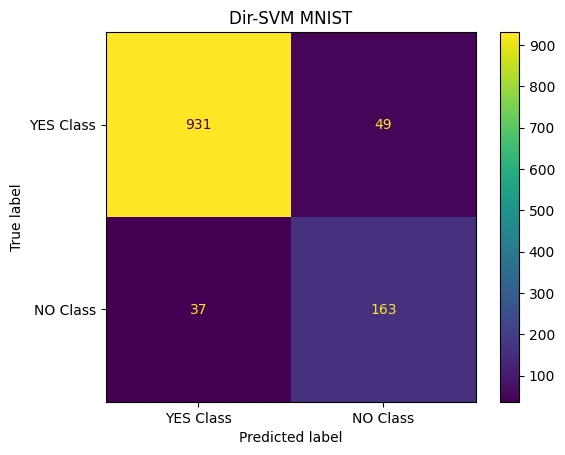

In [24]:
cm = confusion_matrix(y_test, y_pred_svm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['YES Class', 'NO Class'])
cm_display.plot()
cm_display.ax_.set_title('Dir-SVM MNIST')
plt.show()